In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install sentencepiece
# !wget https://raw.githubusercontent.com/google/sentencepiece/master/data/botchan.txt

In [3]:
import json
import tensorflow as tf
import sentencepiece as spm
from tqdm.notebook import tqdm
import numpy as np
import os
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

# 데이터 로드

In [46]:
train_json_path = '/aiffel/aiffel/bert_qna/data/KorQuAD_v1.0_train.json'
dev_json_path = '/aiffel/aiffel/bert_qna/data/KorQuAD_v1.0_dev.json'
k_model_path = '/aiffel/aiffel/bert_qna/models/ko_32000.model'
new_train_json_path = '/aiffel/aiffel/bert_qna/data/KorQuAD_train.json'
new_dev_json_path = '/aiffel/aiffel/bert_qna/data/KorQuAD_dev.json'
pretrained_model_path = '/aiffel/aiffel/bert_qna/models/bert_pretrain_32000.hdf5'

# train_json_path = '/content/drive/MyDrive/Aiffel/Exploration/E17/KorQuAD_v1.0_train.json'
# dev_json_path = '/content/drive/MyDrive/Aiffel/Exploration/E17/KorQuAD_v1.0_dev.json'
# k_model_path = '/content/drive/MyDrive/Aiffel/Exploration/E17/ko_32000.model'
# new_train_json_path = '/content/drive/MyDrive/Aiffel/Exploration/E17/KorQuAD_train.json'
# new_dev_json_path = '/content/drive/MyDrive/Aiffel/Exploration/E17/KorQuAD_dev.json'
# pretrained_model_path = '/content/drive/MyDrive/Aiffel/Exploration/E17/bert_pretrain_32000.hdf5'

In [5]:
# 리스트의 첫번째 아이템 출력
def print_json_tree(data, indent=""):
    for key, value in data.items():
        if type(value) == list:     # list 형태의 item은 첫번째 item만 출력
            print(f'{indent}- {key}: [{len(value)}]')
            print_json_tree(value[0], indent + "  ")
        else:
            print(f'{indent}- {key}: {value}')

In [6]:
# 훈련데이터
with open(train_json_path) as f:
    train_json = json.load(f)
    print_json_tree(train_json)

- version: KorQuAD_v1.0_train
- data: [1420]
  - paragraphs: [3]
    - qas: [8]
      - answers: [1]
        - text: 교향곡
        - answer_start: 54
      - id: 6566495-0-0
      - question: 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
    - context: 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
  - title: 파우스트_서곡


In [7]:
# 검증데이터 확인
with open(dev_json_path) as f:
    dev_json = json.load(f)
    print_json_tree(dev_json)

- version: KorQuAD_v1.0_dev
- data: [140]
  - paragraphs: [2]
    - qas: [7]
      - answers: [1]
        - text: 1989년 2월 15일
        - answer_start: 0
      - id: 6548850-0-0
      - question: 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
    - context: 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
  - title: 임종석


# 데이터 전처리

## 띄어쓰기 단위 정보관리

In [8]:
# 공백 확인 함수
def _is_whitespace(c):
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False

In [9]:
# 공백을 기준으로 토큰화 함수
def _tokenize_whitespace(string):
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True

    for c in string:
        if _is_whitespace(c):
            prev_is_whitespace = True
        else:
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
                word_tokens[-1] += c
            prev_is_whitespace = False    
        char_to_word.append(len(word_tokens) - 1)
    
    return word_tokens, char_to_word

In [10]:
# string1에 대해 띄어쓰기 영역 표시
string1 = '1839년 파우스트를 읽었다.'
word_tokens, char_to_word = _tokenize_whitespace(string1)
for c, i in zip(list(string1), char_to_word):
    print(f'\'{c}\' : {i}')

word_tokens, char_to_word

'1' : 0
'8' : 0
'3' : 0
'9' : 0
'년' : 0
' ' : 0
'파' : 1
'우' : 1
'스' : 1
'트' : 1
'를' : 1
' ' : 1
'읽' : 2
'었' : 2
'다' : 2
'.' : 2


(['1839년', '파우스트를', '읽었다.'], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

## Tokenize by Vocab

In [11]:
# SentencePiece 함수
def _tokenize_vocab(vocab, context_words):
    word_to_token = []
    context_tokens = []
    for (i, word) in enumerate(context_words):
        word_to_token.append(len(context_tokens))
        tokens = vocab.encode_as_pieces(word)
        for token in tokens:
            context_tokens.append(token)
    return context_tokens, word_to_token

In [12]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(k_model_path)

True

In [13]:
print(word_tokens)  # 처리해야 할 word 단위 입력

context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
context_tokens, word_to_token   # Subword 단위로 토큰화한 결과

['1839년', '파우스트를', '읽었다.']


(['▁1839', '년', '▁', '파우스트', '를', '▁읽', '었다', '.'], [0, 2, 5])

## Improve Span

In [14]:
context = train_json['data'][0]['paragraphs'][0]['context']
question = train_json['data'][0]['paragraphs'][0]['qas'][0]['question']
answer_text = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['text']
answer_start = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['answer_start']
answer_end = answer_start + len(answer_text) - 1

print('[context] ', context)
print('[question] ', question)
print('[answer] ', answer_text)
print('[answer_start] index: ', answer_start, 'character: ', context[answer_start])
print('[answer_end]index: ', answer_end, 'character: ', context[answer_end])

# answer_text에 해당하는 context 영역을 정확히 찾아내야 합니다. 
assert context[answer_start:answer_end + 1] == answer_text

[context]  1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
[question]  바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
[answer]  교향곡
[answer_start] index:  54 character:  교
[answer_end]index:  56 character:  곡


In [15]:
# context를 띄어쓰기(word) 단위로 토큰화한 결과를 살펴봅니다. 
word_tokens, char_to_word = _tokenize_whitespace(context)

print( word_tokens[:20])

char_to_word[:20], context[:20]

['1839년', '바그너는', '괴테의', '파우스트을', '처음', '읽고', '그', '내용에', '마음이', '끌려', '이를', '소재로', '해서', '하나의', '교향곡을', '쓰려는', '뜻을', '갖는다.', '이', '시기']


([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3],
 '1839년 바그너는 괴테의 파우스트을')

In [16]:
# 띄어쓰기(word) 단위로 쪼개진 context(word_tokens)를 Subword로 토큰화한 결과를 살펴봅니다. 
context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
for i in range(min(20, len(word_to_token) - 1)):
    print(word_to_token[i], context_tokens[word_to_token[i]:word_to_token[i + 1]])

0 ['▁1839', '년']
2 ['▁바그너', '는']
4 ['▁괴테', '의']
6 ['▁', '파우스트', '을']
9 ['▁처음']
10 ['▁읽고']
11 ['▁그']
12 ['▁내용에']
13 ['▁마음이']
14 ['▁끌려']
15 ['▁이를']
16 ['▁소재로']
17 ['▁해서']
18 ['▁하나의']
19 ['▁교향곡', '을']
21 ['▁쓰', '려는']
23 ['▁뜻을']
24 ['▁갖는다', '.']
26 ['▁이']
27 ['▁시기']


In [17]:
# answer_start와 answer_end로부터 word_start와 word_end를 구합니다. 
word_start = char_to_word[answer_start]
word_end = char_to_word[answer_end]
word_start, word_end, answer_text, word_tokens[word_start:word_end + 1]

(14, 14, '교향곡', ['교향곡을'])

In [18]:
token_start = word_to_token[word_start]
if word_end < len(word_to_token) - 1:
    token_end = word_to_token[word_end + 1] - 1
else:
    token_end = len(context_tokens) - 1
token_start, token_end, context_tokens[token_start:token_end + 1]

(19, 20, ['▁교향곡', '을'])

In [19]:
# 실제 정답인 answer_text도 Subword 기준으로 토큰화해 둡니다. 
token_answer = " ".join(vocab.encode_as_pieces(answer_text))
token_answer

'▁교향곡'

In [20]:
# 정답이 될수 있는 new_start와 new_end의 경우를 순회탐색합니다. 
for new_start in range(token_start, token_end + 1):
    for new_end in range(token_end, new_start - 1, -1):
        text_span = " ".join(context_tokens[new_start : (new_end + 1)])
        if text_span == token_answer:   # 정답과 일치하는 경우
            print("O >>", (new_start, new_end), text_span)
        else:
            print("X >>", (new_start, new_end), text_span)

X >> (19, 20) ▁교향곡 을
O >> (19, 19) ▁교향곡
X >> (20, 20) 을


In [21]:
# context_tokens에서 char_answer의 위치를 찾아 리턴하는 함수
def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
    return (token_start, token_end)

In [22]:
token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, answer_text)
print('token_start:', token_start, ' token_end:', token_end)
context_tokens[token_start:token_end + 1]

token_start: 19  token_end: 19


['▁교향곡']

## 데이터셋 분리

In [23]:
def dump_korquad(vocab, json_data, out_file):
    with open(out_file, "w") as f:
        for data in tqdm(json_data["data"]):
            title = data["title"]
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)

                for qa in paragraph["qas"]:
                    assert len(qa["answers"]) == 1
                    qa_id = qa["id"]
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1

                    assert answer_text == context[answer_start:answer_end + 1]

                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]

                    word_answer = " ".join(context_words[word_start:word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    assert char_answer in word_answer

                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)

                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1

                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)

                    data = {"qa_id": qa_id, "title": title, "question": vocab.encode_as_pieces(question), "context": context_tokens, "answer": char_answer, "token_start": token_start, "token_end":token_end}
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")

In [24]:
# 전처리를 수행하여 파일로 생성합니다. 
dump_korquad(vocab, train_json, new_train_json_path)
dump_korquad(vocab, dev_json, new_dev_json_path)

  0%|          | 0/1420 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

## 데이터 로드

In [25]:
train_json = new_train_json_path
dev_json = new_dev_json_path

In [26]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


args = Config({
    'max_seq_length': 384,
    'max_query_length': 64,
})

In [27]:
# 생성한 데이터셋 파일을 메모리에 로딩하는 함수
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = args.max_seq_length - len(question) - 3

            if token_end >= context_len:
                # 최대 길이내에 token이 들어가지 않은 경우 처리하지 않음
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f'n_discard: {n_discard}')

    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

In [28]:
# train data load
train_inputs, train_labels = load_data(args, train_json)
print(f"train_inputs: {train_inputs[0].shape}")
print(f"train_inputs: {train_inputs[1].shape}")
print(f"train_labels: {train_labels[0].shape}")
print(f"train_labels: {train_labels[1].shape}")

# dev data load
dev_inputs, dev_labels = load_data(args, dev_json)
print(f"dev_inputs: {dev_inputs[0].shape}")
print(f"dev_inputs: {dev_inputs[1].shape}")
print(f"dev_labels: {dev_labels[0].shape}")
print(f"dev_labels: {dev_labels[1].shape}")

train_inputs[:10], train_labels[:10]

Loading ...: 0it [00:00, ?it/s]

n_discard: 430
train_inputs: (59977, 384)
train_inputs: (59977, 384)
train_labels: (59977,)
train_labels: (59977,)


Loading ...: 0it [00:00, ?it/s]

n_discard: 78
dev_inputs: (5696, 384)
dev_inputs: (5696, 384)
dev_labels: (5696,)
dev_labels: (5696,)


((array([[    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    19, ...,     0,     0,     0],
         ...,
         [    5, 21666,    19, ...,     0,     0,     0],
         [    5,   964, 16865, ...,     0,     0,     0],
         [    5,   365,    15, ...,     0,     0,     0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 (array([ 37, 184,  98, ...,  74, 190,  35]),
  array([ 37, 185, 102, ...,  75, 191,  44])))

# pretrained model 로딩하기

In [29]:
# 유틸리티 함수들

def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer


class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [30]:
# mode == "embedding" 일 경우 Token Embedding Layer 로 사용되는 layer 클래스입니다. 

class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [31]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [32]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [33]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [34]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [35]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [36]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        """
        layer 실행
        :param enc_tokens: encoder tokens
        :param segments: token segments
        :return logits_cls: CLS 결과 logits
        :return logits_lm: LM 결과 logits
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

In [37]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) # (bs, n_seq, 2)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

In [38]:
config = Config({"d_model": 512, "n_head": 8, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 6, "n_seq": 384, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 512,
 'n_head': 8,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 6,
 'n_seq': 384,
 'n_vocab': 32007,
 'i_pad': 0}

In [39]:
bert_batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

In [40]:
checkpoint_file = pretrained_model_path

model = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    model.load_weights(pretrained_model_path, by_name=True)

    model.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  29202944  
_________________________________________________________________
dense_36 (Dense)             multiple                  1026      
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


# pretrained model finetune 하기

In [41]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [42]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [43]:
history = {'train_loss':[], 'train_accuracy':[], 'val_loss': [], 'val_accuracy': []}
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0
for epoch in range(20):
    train_start_loss, train_end_loss, train_start_acc, train_end_acc = train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    val_start_loss, val_end_loss, val_start_acc, val_end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> validation loss: {val_start_loss:0.4f}, {val_end_loss:0.4f}, validation acc: {val_start_acc:0.4f}, {val_end_acc:0.4f}')
    val_acc = val_start_acc + val_end_acc
    
    if best_acc < val_acc:
        patience = 0
        best_acc = val_acc
        model.save_weights("korquad_bert_none_pretrain.hdf5")
        print(f'save best model')
    else:
        patience += 1
    if 5 <= patience:
        print(f'early stopping')
        break
    
    # 검증 데이터에 대한 학습 진행 상황을 저장
    history['train_loss'].append(train_start_loss+train_end_loss)
    history['train_accuracy'].append(train_start_acc+train_end_acc)
    history['val_loss'].append(val_start_loss+val_end_loss)
    history['val_accuracy'].append(val_acc)

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> validation loss: 1.7756, 2.0213, validation acc: 0.5400, 0.5051
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> validation loss: 1.7011, 1.9585, validation acc: 0.5644, 0.5349
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> validation loss: 1.7106, 1.9348, validation acc: 0.5739, 0.5248


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> validation loss: 1.8840, 2.1723, validation acc: 0.5671, 0.5105


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 4 >> validation loss: 1.9643, 2.2059, validation acc: 0.5709, 0.5133


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 5 >> validation loss: 2.3425, 2.7204, validation acc: 0.5553, 0.5068


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 6 >> validation loss: 2.7374, 2.9365, validation acc: 0.5507, 0.5098
early stopping


# Inference 수행하기

In [44]:
def do_predict(model, question, context):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param question: 입력 문자열
    :param context: 입력 문자열
    """
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

In [47]:
with open(new_dev_json_path) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 100 < i:
            break

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 

1
질문 :  1989년 6월 30일 평양축전에 대표로 파견 된 인물은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임

# 학습 경과 시각화 비교분석

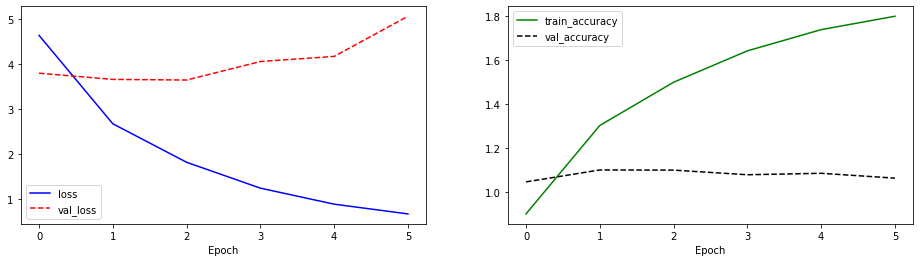

In [49]:
# loss와 accuracy 시각화
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], 'b-', label='loss')
plt.plot(history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], 'g-', label='train_accuracy')
plt.plot(history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

# 회고
- 이번 프로젝트에서 어려웠던 점
    - 이번 프로젝트의 학습은 상당히 많은 시간과 메모리가 사용되면서 코드 수정하는데 많은 시간이 소요되었다.
- 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
    - pretrained model을 fine tuning을 어떻게 효과적으로 할 수 있는지 막막하다.
- 자기 다짐
    - 해커톤 프로젝트를 하기 전에 효과적으로 fine tuning하는 방법 등 다양한 기법들을 익혀야겠다.